# Lets Run a Hybrid Search

In this notebook we'll learn about how to use a ML model to enrich our Icecat data with vectors, and then we'll balance a lexical search with a neural search.

In [1]:
import requests
import json
import mercury as mr
import time

app = mr.App(title="Let's Run a Hybrid Search", static_notebook=True)

mercury.App

## Configure ml plugin

In [2]:
url = "http://localhost:9200/_cluster/settings"
headers = {
    'Content-Type': 'application/json'
}

payload = {
    "persistent": {
        "plugins": {
            "ml_commons": {
                "only_run_on_ml_node": "false",
                "model_access_control_enabled": "true",
                "native_memory_threshold": "99"
            }
        }
    }
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))



In [3]:
mr.JSON(response.json(), level=4)

## Register a model group

In [4]:
url = "http://localhost:9200/_plugins/_ml/model_groups/_register"

payload = {
  "name": "NLP_model_group",
  "description": "A model group for NLP models"
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

model_group_id = response.json()['model_group_id']

print(f"Created Model Group ID {model_group_id}")

Created Model Group ID _GNOnpEBmRRht9-svOPT


## Register the model to the model group
Under the covers we are downloading from HuggingFace 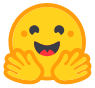 the model and saving it into our cluster.  This can take some time!

In [5]:
url = "http://localhost:9200/_plugins/_ml/models/_register"

# Previously had huggingface/sentence-transformers/msmarco-distilbert-base-tas-b

payload = {
  "name": "huggingface/sentence-transformers/all-MiniLM-L6-v2",
  "version": "1.0.1",
  "model_group_id": model_group_id,
  "model_format": "TORCH_SCRIPT"
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)
task_id = response.json()['task_id']

## Check status of registering model

In [6]:
url = f"http://localhost:9200/_plugins/_ml/tasks/{task_id}"

max_attempts = 10
attempts = 0

state = None
while state != 'COMPLETED' and attempts < max_attempts:
    time.sleep(5) # wait five second and then check again.  We are downloading msmarco model from huggingface.
    response = requests.request("GET", url, headers=headers)
    mr.JSON(response.json(), level=4)
    state = response.json()['state']
    

model_id = response.json()['model_id']

print(f"Created Model ID {model_id}")

Created Model ID _mNOnpEBmRRht9-sw-Nz


## Wait ten seconds to avoid memory issues?
We have been hitting memory circuit issues...

In [7]:
time.sleep(10)

## Deploy the model
Under the covers we are downloading and deploying into OpenSearch pytorch4j!

In [8]:
url = f"http://localhost:9200/_plugins/_ml/models/{model_id}/_deploy"

response = requests.request("POST", url, headers=headers)
mr.JSON(response.json(), level=4)
deploy_model_task_id = response.json()['task_id']

## Check the status

In [9]:
url = f"http://localhost:9200/_plugins/_ml/tasks/{deploy_model_task_id}"

max_attempts = 10
attempts = 0

state = None
while state != 'COMPLETED' and attempts < max_attempts:
    attempts += 1
    time.sleep(5) # wait five second and then check again.  Deploying the model can take a while
    response = requests.request("GET", url, headers=headers)
    mr.JSON(response.json(), level=4)
    state = response.json()['state']
    
    

model_id = response.json()['model_id']

### Test out using the Model to create sentence embeddings

In [10]:
url = f"http://localhost:9200/_plugins/_ml/_predict/text_embedding/{model_id}"

payload = {
  "text_docs":[ "today is sunny"],
  "return_number": True,
  "target_response": ["sentence_embedding"]
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=6)

## Create an ingest pipeline
Here we are creating a embedding using our model on the title field called `title_embedding` that we can refer to later

In [18]:
url = "http://localhost:9200/_ingest/pipeline/nlp-ingest-pipeline"

payload = {
  "description": "A text embedding pipeline",
  "processors": [
    {
      "text_embedding": {
        "model_id": model_id,
        "field_map": {
          "title": "title_embedding"
        }
      }
    }
  ]
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)


## Create an index for ingestion

In [19]:
url = "http://localhost:9200/my-nlp-index"

response = requests.request("DELETE", url, headers=headers)

payload = {
  "settings": {
    "index.knn": True,
    "default_pipeline": "nlp-ingest-pipeline"
  },
  "mappings": {
    "properties": {
      "id": {
        "type": "text"
      },
      "title_embedding": {
        "type": "knn_vector",
        "dimension": 384,
        "method": {
          "engine": "lucene",
          "space_type": "l2",
          "name": "hnsw",
          "parameters": {}
        }
      },
      "title": {
        "type": "text"
      }
    }
  }
}
response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

## Ingest documents into the index

#### Document 1

In [20]:
url = "http://localhost:9200/my-nlp-index/_doc/1"

payload = {
  "title": "Xerox 006R90321 toner cartridge Original Black 6 pc(s)",
  "id": "s1"
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=1)

#### Document 2

In [21]:
url = "http://localhost:9200/my-nlp-index/_doc/2"

payload = {
  "title": "Labels Premium A4 64.6x33.8 mm white paper matt 2400 pcs.",
  "id": "s2"
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=1)

## Configure a search pipeline

In [22]:
url = "http://localhost:9200/_search/pipeline/nlp-search-pipeline"

payload = {
  "description": "Post processor for hybrid search",
  "phase_results_processors": [
    {
      "normalization-processor": {
        "normalization": {
          "technique": "min_max"
        },
        "combination": {
          "technique": "arithmetic_mean",
          "parameters": {
            "weights": [
              0.3,
              0.7
            ]
          }
        }
      }
    }
  ]
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

## Search the index using just Neural search
Notice that our query *Hi world* which has nothing to do with either toner cartidges or paper returns matches?  Yeah, that's where the kNN algorithm falls down..  

In [23]:
url = "http://localhost:9200/my-nlp-index/_search"

payload = {
  "_source": {
    "exclude": [
      "title_embedding"
    ]
  },
  "query": {
    "hybrid": {
      "queries": [
        {
          "neural": {
            "title_embedding": {
              "query_text": "Hi world",
              "model_id": model_id,
              "k": 5
            }
          }
        }
      ]
    }
  }
}


response = requests.request("GET", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=5)

## Combining neural and lexical match query

Notice that we add to the mix both a lexical (_match_) and a neural query.  They are blended by the `nlp-search-pipeline` that we reference.

In [24]:
url = "http://localhost:9200/my-nlp-index/_search?search_pipeline=nlp-search-pipeline"

payload = {
  "_source": {
    "excludes": [
      "title_embedding"
    ]
  },
  "query": {
    "hybrid": {
      "queries": [
        {
          "match": {
            "title_text": {
              "query": "printer toner"
            }
          }
        },
        {
          "neural": {
            "title_embedding": {
              "query_text": "printer toner",
              "model_id": model_id,
              "k": 5
            }
          }
        }
      ]
    }
  }
}


response = requests.request("GET", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=5)